In [1]:
import gluonbook as gb
import mxnet as mx
from mxnet import autograd,gluon,image,init,nd
from mxnet.gluon import data as gdata, loss as gloss,utils as gutils
from time import time
%matplotlib inline
import matplotlib.pyplot as plt

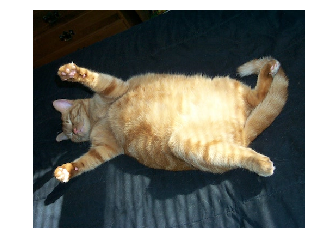

In [2]:
img=image.imread('../img/cat1.jpg')
plt.axis('off')
#plt.xticks([])
#plt.yticks([])
plt.imshow(img.asnumpy())

In [3]:
def apply(img,aug,num_rows=2,num_cols=4):
    Y=[aug(img) for _ in range(num_rows*num_cols)]
    for i,img in enumerate(Y):
        fig=plt.subplot(num_rows,num_cols,i+1)
        plt.axis('off')
        plt.imshow(img.asnumpy())

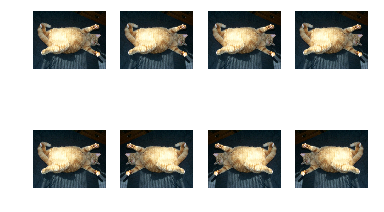

In [4]:

apply(img,gdata.vision.transforms.RandomFlipLeftRight())

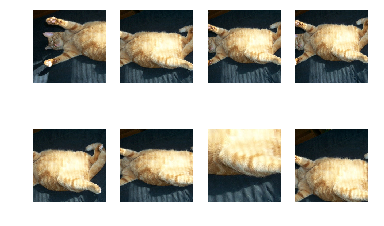

In [5]:
apply(img,gdata.vision.transforms.RandomResizedCrop((200,200)))
shape_aug=gdata.vision.transforms.RandomResizedCrop((200,200))

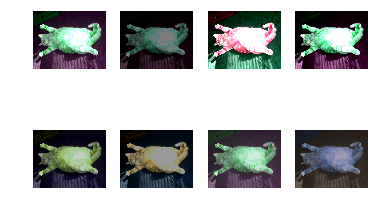

In [6]:
apply(img,gdata.vision.transforms.RandomColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.5))
color_aug=gdata.vision.transforms.RandomColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.5)

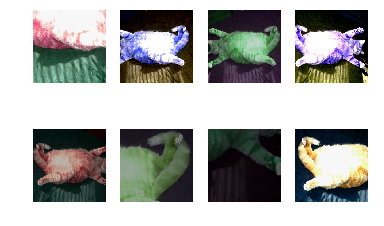

In [7]:
augs=gdata.vision.transforms.Compose([gdata.vision.transforms.RandomFlipLeftRight(),color_aug,shape_aug])
apply(img,augs)


In [8]:
def show_img(imgs,num_rows,num_cols):
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.axis('off')
        plt.imshow(img.asnumpy())

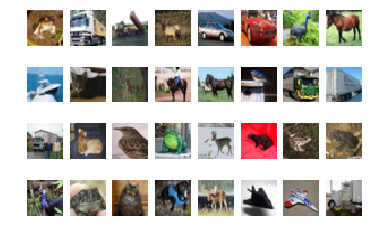

In [9]:

show_img(gdata.vision.CIFAR10(train=True)[:32][0],4,8)

In [10]:
train_set=gdata.vision.CIFAR10(train=True)
test_set=gdata.vision.CIFAR10(train=False)

In [11]:
batch_size,num_workers=256,4
train_augs=gdata.vision.transforms.Compose([gdata.vision.transforms.RandomFlipLeftRight(),gdata.vision.transforms.ToTensor()])
test_augs=gdata.vision.transforms.ToTensor()
train_iter=gdata.DataLoader(train_set.transform_first(train_augs),shuffle=True,batch_size=batch_size,num_workers=num_workers)
test_iter=gdata.DataLoader(test_set.transform_first(test_augs),shuffle=False,batch_size=batch_size,num_workers=num_workers)

In [12]:
def accuracy(data_iter,net,ctx):
    acc=0.0
    for X,y in  data_iter:
        acc+=(net(X.copyto(ctx)).argmax(1)==y.astype('float32').copyto(ctx)).mean()
    return (acc/(len(data_iter))).asscalar()

In [13]:
def train(train_iter,test_iter,net,loss,trainer,ctx,num_epochs,batch_size):
    for epoch in range(num_epochs):
        start=time()
        for X,y in train_iter:
            X=X.copyto(ctx)
            y=y.copyto(ctx)
            with autograd.record():
                l=loss(net(X),y)
            l.backward()
            trainer.step(batch_size)
        train_acc=accuracy(train_iter,net,ctx)
        test_acc=accuracy(test_iter,net,ctx)
        print('epoch %d,train acc %f ,test acc %f,time %.1f'%(epoch,train_acc,test_acc,time()-start))
    

In [14]:
lr=0.001
net=gb.resnet18(10)
ctx=mx.gpu()
net.initialize(force_reinit=True,ctx=ctx,init=init.Xavier())
loss=gloss.SoftmaxCrossEntropyLoss()
trainer=gluon.Trainer(net.collect_params(),'adam',{'learning_rate':lr})
num_epochs,batch_size=10,256
train(train_iter,test_iter,net,loss,trainer,ctx,num_epochs,batch_size)

MXNetError: [09:10:26] src/storage/./pooled_storage_manager.h:108: cudaMalloc failed: out of memory

Stack trace returned 10 entries:
[bt] (0) /home/tomoya/.local/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x30756a) [0x7fb03119556a]
[bt] (1) /home/tomoya/.local/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x307b91) [0x7fb031195b91]
[bt] (2) /home/tomoya/.local/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x29d67b3) [0x7fb0338647b3]
[bt] (3) /home/tomoya/.local/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x29db065) [0x7fb033869065]
[bt] (4) /home/tomoya/.local/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x440e64) [0x7fb0312cee64]
[bt] (5) /home/tomoya/.local/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x24f085d) [0x7fb03337e85d]
[bt] (6) /home/tomoya/.local/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x24f0d33) [0x7fb03337ed33]
[bt] (7) /home/tomoya/.local/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x2468d49) [0x7fb0332f6d49]
[bt] (8) /home/tomoya/.local/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x2472944) [0x7fb033300944]
[bt] (9) /home/tomoya/.local/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x24767e3) [0x7fb0333047e3]

